***Data Science/ML Project***

For this project, I have applied text analysis, visualizations and text preprocessing and have implemented various deep neural networks with TensorFlow for training. 

<!-- I have created multiple-input neural networks for regression and using functional API. The first input includes titles only and the second input includes these features: date and time_cretaed, author, title_length and number of stop_words. The target variable whose values are predicted is up_votes.  -->


# Text Analysis

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored
sns.set(style='ticks', palette='Set2')
import warnings
warnings.filterwarnings('ignore') 

import time
import os
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')

import imblearn
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Conv1D, MaxPooling1D, Activation
from tensorflow.keras.layers import concatenate, BatchNormalization, GlobalAveragePooling1D
from keras.utils.vis_utils import plot_model


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# Download and read the csv file 
orig_url='https://drive.google.com/file/d/15X00ZWBjla7qGOIW33j8865QdF89IyAk/view?usp=sharing'
file_id = orig_url.split('/')[-2]

dwn_url='https://drive.google.com/uc?export=download&id=' + file_id

df = pd.read_csv(dwn_url)
df.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


In [242]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509236 entries, 0 to 509235
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   time_created  509236 non-null  int64 
 1   date_created  509236 non-null  object
 2   up_votes      509236 non-null  int64 
 3   down_votes    509236 non-null  int64 
 4   title         509236 non-null  object
 5   over_18       509236 non-null  bool  
 6   author        509236 non-null  object
 7   category      509236 non-null  object
dtypes: bool(1), int64(3), object(4)
memory usage: 27.7+ MB


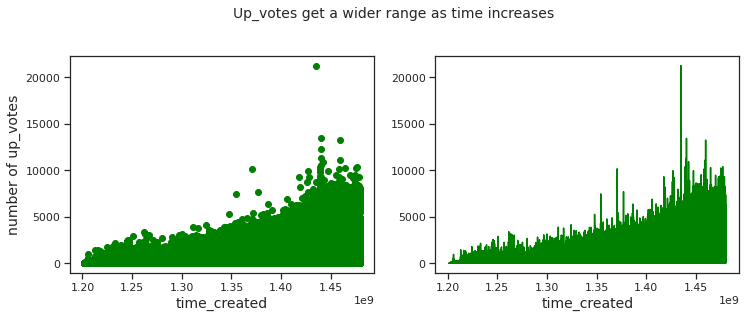

In [3]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(df.time_created, df.up_votes, color='g')
plt.xlabel('time_created', fontsize=14)
plt.ylabel('number of up_votes', fontsize=14)
plt.suptitle('Up_votes get a wider range as time increases', fontsize=14, y=1.05)
plt.subplot(122)
plt.plot(df.time_created, df.up_votes, color='g')
plt.xlabel('time_created', fontsize=14)
plt.show()

     date_created  Average of up_votes
0      2008-01-25             4.714286
1      2008-01-28             2.000000
2      2008-01-29             3.000000
3      2008-01-30             4.666667
4      2008-01-31             3.200000
...           ...                  ...
3218   2016-11-18           171.970260
3219   2016-11-19           251.974093
3220   2016-11-20           195.574766
3221   2016-11-21           173.245968
3222   2016-11-22            52.291391

[3223 rows x 2 columns] 



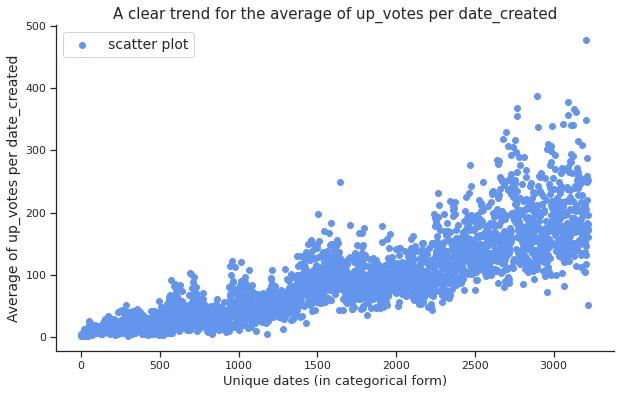

In [4]:
# Average of up_votes per date_created
df_1 = df.groupby('date_created')['up_votes'].mean().reset_index(name='Average of up_votes')
print(df_1, '\n')
x = pd.factorize(df.date_created.unique())[0]

plt.figure(figsize=(10,6))
plt.scatter(x, df_1['Average of up_votes'], color='cornflowerblue', label='scatter plot')
plt.title('A clear trend for the average of up_votes per date_created', fontsize=15)
plt.legend(fontsize=14)
plt.xlabel('Unique dates (in categorical form)', fontsize=13)
plt.ylabel('Average of up_votes per date_created', fontsize=14)
sns.despine()

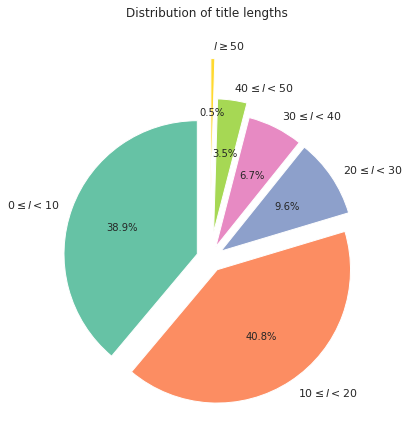

In [5]:
# Create a new column title_length
df['title_length'] = df.title.apply(lambda x: len(x.split())) 

# Calculate its distribution
labels = '$0\leq l<10$' , '$10\leq l<20$', '$20\leq l<30$',\
          '$30\leq l<40$', '$40\leq l<50$', '$l\geq50$'
percent  = {}
for i in range(5):
  percent[i] = len([x for x in df.title_length if 10*i<=x<10*i+10]) / len(df.title_length)
percent[6] = len([x for x in df.title_length if x>=50]) / len(df.title_length)

explode = (0.1, 0.1, 0.1, 0.1, 0.2, 0.5)
fig, ax = plt.subplots(figsize=(7,7))
ax.pie(percent.values(), explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  
ax.set_title('Distribution of title lengths', y=1.05)
plt.show()

First 5 rows of df : 
    time_created date_created  up_votes  ...    author   category  title_length
0    1201232046   2008-01-25         3  ...     polar  worldnews             5
1    1201232075   2008-01-25         2  ...     polar  worldnews             4
2    1201232523   2008-01-25         3  ...     polar  worldnews             6
3    1201233290   2008-01-25         1  ...   fadi420  worldnews             7
4    1201274720   2008-01-25         4  ...  mhermans  worldnews             7

[5 rows x 9 columns] 

First 5 rows of df_2 : 
     title_length  Average of up_votes
0             1             0.554622
1             2            27.263923
2             3            51.858113
3             4            60.725634
4             5            55.916472 



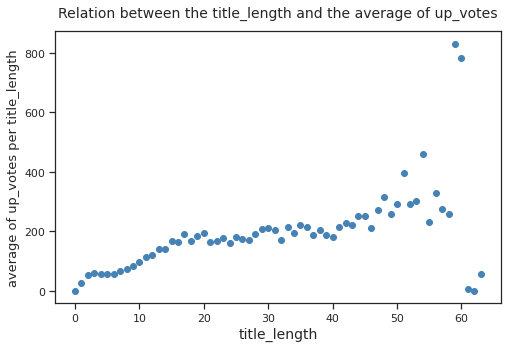

In [6]:
# Calculate the average of up_votes per title_length
df_2 = df.groupby('title_length')['up_votes'].mean().reset_index(name='Average of up_votes')

print(colored('First 5 rows of df', 'blue'),': \n', df.head(), '\n')
print(colored('First 5 rows of df_2', 'blue'),': \n ', df_2.head(), '\n')

# Plot
plt.figure(figsize=(8,5))
plt.scatter(np.arange(64), df_2['Average of up_votes'], color='steelblue')
plt.title('Relation between the title_length and the average of up_votes', fontsize=14, y=1.03)
plt.xlabel('title_length', fontsize=14)
plt.ylabel('average of up_votes per title_length', fontsize=13)
plt.show()

In [7]:
# Create two colums: number of stop_words in each title
# and the percentage of stop_words
cachedStopWords = stopwords.words('english')

def num_stop_words(text):
  return len(set(text.lower().split()).intersection(cachedStopWords))

df['num_stop_words'] = df.title.apply(lambda x: num_stop_words(x))
df['percentage_of_stop_words'] = df.num_stop_words/df.title_length
df.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category,title_length,num_stop_words,percentage_of_stop_words
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews,5,1,0.200000
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews,4,0,0.000000
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews,6,1,0.166667
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews,7,2,0.285714
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews,7,1,0.142857


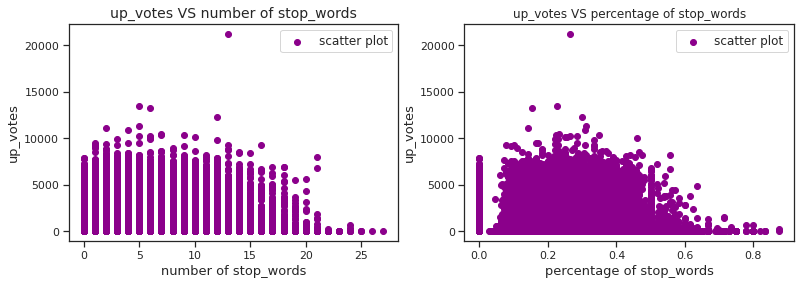

In [8]:
# Plot
x1 = df.num_stop_words
x2 = df.percentage_of_stop_words
y = df.up_votes

plt.figure(figsize=(13,4))
plt.subplot(121)
plt.scatter(x1, y, label='scatter plot', color='darkmagenta')
plt.title('up_votes VS number of stop_words', fontsize=14)
plt.legend(fontsize=12)
plt.xlabel('number of stop_words', fontsize=13)
plt.ylabel('up_votes', fontsize=13)
plt.subplot(122)
plt.scatter(x2, y, label='scatter plot', color='darkmagenta')
plt.title('up_votes VS percentage of stop_words')
plt.legend(fontsize=12)
plt.xlabel('percentage of stop_words', fontsize=13)
plt.ylabel('up_votes', fontsize=13)
plt.show()

First 5 rows of df_3 : 
    num_stop_words  Average_of_up_votes
0               0            59.912832
1               1            67.619759
2               2            82.207464
3               3           103.325516
4               4           130.545524 

First 5 rows of df_4 : 
    percentage_of_stop_words  Average_of_up_votes
0                  0.000000            59.912832
1                  0.028571             0.000000
2                  0.030303             0.000000
3                  0.040000            10.000000
4                  0.041667             5.000000 



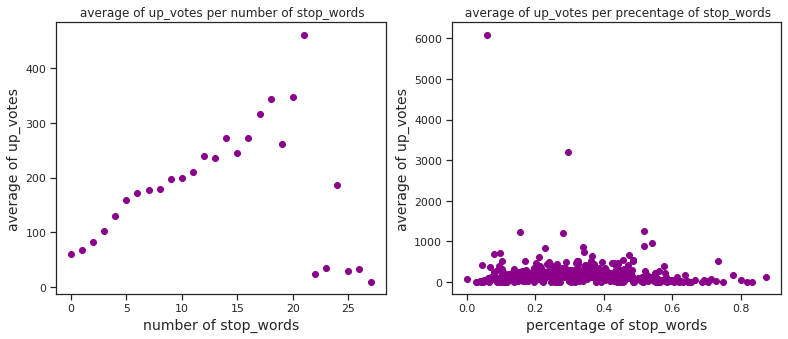

In [9]:
# Calculate the average of up_votes per number of stop_words
# and average of up_votes per percentage of stop_words!
df_3 = df.groupby('num_stop_words')['up_votes'].mean().reset_index(name='Average_of_up_votes')
df_4 = df.groupby('percentage_of_stop_words')['up_votes'].mean().reset_index(name='Average_of_up_votes')

print(colored('First 5 rows of df_3', 'blue'),': \n', df_3.head(), '\n')
print(colored('First 5 rows of df_4', 'blue'),': \n', df_4.head(), '\n')

# Plot
plt.figure(figsize=(13,5))
plt.subplot(121)
plt.scatter(df_3.num_stop_words, df_3.Average_of_up_votes, color='darkmagenta')
plt.title(' average of up_votes per number of stop_words', fontsize=12)
plt.xlabel('number of stop_words', fontsize=14)
plt.ylabel('average of up_votes', fontsize=14)
plt.subplot(122)
plt.scatter(df_4.percentage_of_stop_words, df_4.Average_of_up_votes, color='darkmagenta')
plt.title(' average of up_votes per precentage of stop_words', fontsize=12)
plt.xlabel('percentage of stop_words', fontsize=14)
plt.ylabel('average of up_votes', fontsize=14)
plt.show()

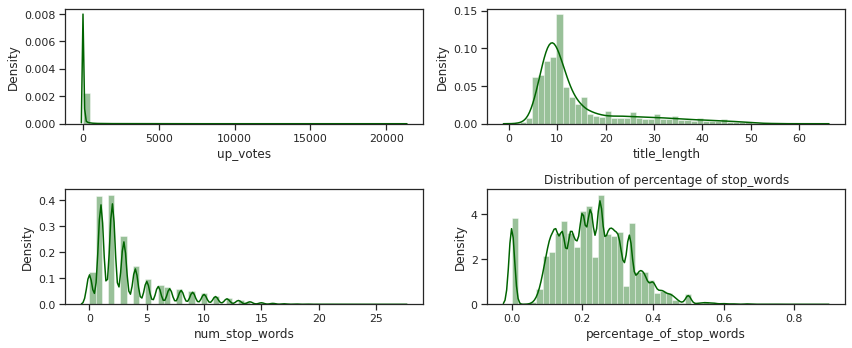

In [250]:
# Distribution of features and target values
fig, ax = plt.subplots(2,2, figsize=(12,5))
sns.distplot(df.up_votes, ax=ax[0,0], color='darkgreen')
plt.title('Distribution of upvotes')
sns.distplot(df.title_length, ax=ax[0,1], color='darkgreen')
plt.xlabel('title length')
plt.title('Distribution of title_length')
sns.distplot(df.num_stop_words, ax=ax[1,0], color='darkgreen')
plt.title('Distribution of stop_words')
sns.distplot(df.percentage_of_stop_words, ax=ax[1,1], color='darkgreen')
plt.title('Distribution of percentage of stop_words')
plt.tight_layout()
plt.show()

From the above density plots we can see that target values (up_votes) are highly imbalanced. 

In [10]:
for i in range(20): 
  print("number of %i's in up_votes =" %i, colored(len(df[df.up_votes==i]),'blue'))

number of 0's in up_votes = 93555
number of 1's in up_votes = 46619
number of 2's in up_votes = 44195
number of 3's in up_votes = 36112
number of 4's in up_votes = 29917
number of 5's in up_votes = 25456
number of 6's in up_votes = 20858
number of 7's in up_votes = 16958
number of 8's in up_votes = 13903
number of 9's in up_votes = 11506
number of 10's in up_votes = 9654
number of 11's in up_votes = 8173
number of 12's in up_votes = 7224
number of 13's in up_votes = 6246
number of 14's in up_votes = 5619
number of 15's in up_votes = 5078
number of 16's in up_votes = 4277
number of 17's in up_votes = 3909
number of 18's in up_votes = 3718
number of 19's in up_votes = 3302


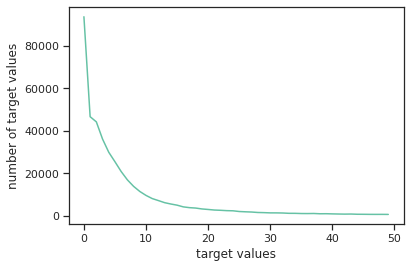

In [11]:
counts = [len(df[df.up_votes==i]) for i in range(50)]
plt.plot(np.arange(50), counts)
plt.xlabel('target values')
plt.ylabel('number of target values')
plt.show()

The plot shows that the number of different target values changes almost uniformly from 1 to the maximum value (maximum of up_votes in the dataset). Learning from these target values would be very difficult as we can't treat them as separate classes. We can rescale them using the third root and treat them as continuous values.  

The second approach is that we can create classes from the target values. For example, the first class includes all examples with zero up_votes and the second class could be all examples with one or two up_votes, etc. In this case, each class would include almost the same number of examples and therefore we can create balanced classes from original dataset. The disadvantage, however, is that we will lose alot of information which exists in the original dataset.

Another similar approach is to consider the average of up_votes per date_created or title_length, etc and predict the average of up_votes. 



In [12]:
df['up_votes_scaled'] = df.up_votes.apply(lambda x: np.round(np.power(x, 1/3), decimals=2))

In [13]:
'''93555 examples with up_votes=0
   90814 examples with up_votes 1 or 2
   91485 examples with up_votes in [3,4,5]
   88276 examples with up_votes in [6,7,...,12]
   85982 examples with up_votes in [13,14,...,69]
   59124 examples with up_votes greater than 70'''

df['up_votes_to_class'] = df.up_votes.apply(lambda x: 0 if x==0
                                         else 1 if 1<=x<=2 
                                         else 2 if 3<=x<=5
                                         else 3 if 6<=x<13
                                         else 4 if 13<=x<70
                                         else 5)

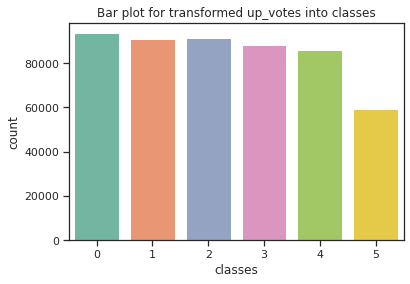

In [14]:
sns.countplot(df.up_votes_to_class)
plt.title('Bar plot for transformed up_votes into classes')
plt.xlabel('classes')
plt.show()

In [15]:
print('original target values = ', df.up_votes.to_numpy())
print('rescaled target values = ', df.up_votes_scaled.to_numpy())
print('transformed target values = ', df.up_votes_to_class.to_numpy())

original target values =  [3 2 3 ... 1 1 1]
rescaled target values =  [1.44 1.26 1.44 ... 1.   1.   1.  ]
transformed target values =  [2 1 2 ... 1 1 1]


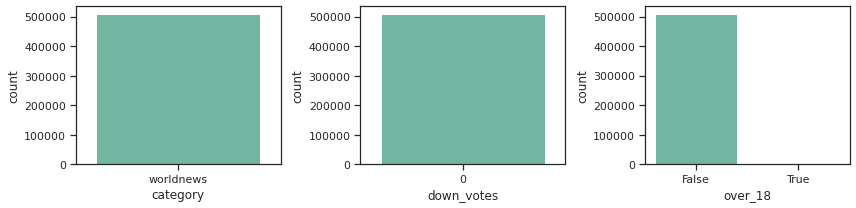

In [16]:
# barplots for 3 features cartegory, down_votes and over_18
fig, ax = plt.subplots(1,3, figsize=(12,3))
sns.countplot(x=df.category, ax=ax[0])
sns.countplot(x=df.down_votes, ax=ax[1])
sns.countplot(x=df.over_18, ax=ax[2])
plt.tight_layout()
plt.show()

In [17]:
# Remove the category and down_votes features
# as they include only one value
df.drop(['down_votes', 'category'], axis=1, inplace=True)

We can get more information from the relation of the features by visualizing the heatmap of correlations.

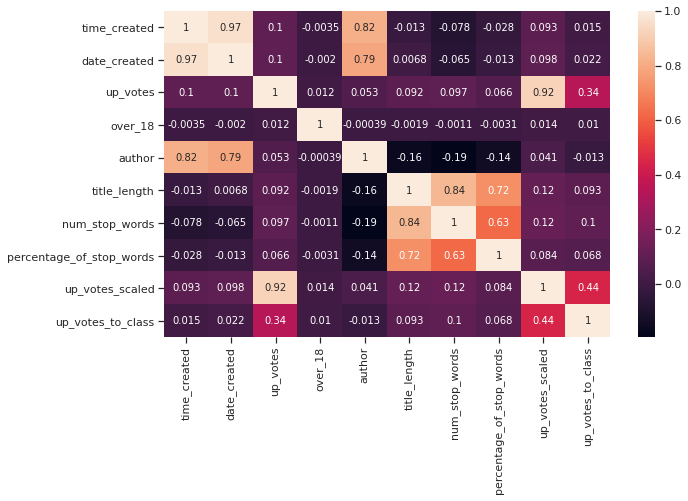

In [18]:
# Correlation of features and target values
correlations = df.loc[:, df.columns!='title'].apply(lambda x:pd.factorize(x)[0]).corr()
plt.figure(figsize=(10,6))
sns.heatmap(correlations, annot=True, cmap=None)
plt.show()

As we can see from the heatmap, features more correlated to up_votes are date and time_created, title_length and num_stop_words. This can be also seen from the above scatter plots for the ***average of up_votes***. In those scatter plots we could see a trend for the ***average of up_votes***. 

Surprisingly, compared to other features, the author feature is less correlated to the up_votes.

Percentage_of_stop_words is also not correlated to the up_votes that much. In the scatter plots also we can't see any trend for the up_votes or the average of up_votes versus percentage of stop_words.

The transfromed target values (up_votes_to_class) have lost correlations with time and date_creared, but still have the same correlation with title_length and num_stop_words as the original target values have.

Finally, I will remove over_18 feature becuase it's unbalanced and poorly correlated to the up_votes.

In [19]:
df.drop(['over_18'], axis=1, inplace=True)

# Text Preprocessing

In [261]:
# Create functions to preprocess raw texts 
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from keras.preprocessing.text import text_to_word_sequence

lemmatize = WordNetLemmatizer().lemmatize
stemmer = SnowballStemmer('english', ignore_stopwords=False)

# Remove stop_wrods and stemmize and lemmatize(if verbs) the remaining words
def stem_lemma(splitted_doc):
  return ' '.join([stemmer.stem(lemmatize(word, 'v')) for word in splitted_doc
                   if not word in cachedStopWords])

# Further standardization: lowercases, removes punctuations and splits the texts 
def standardization(corpus):
  splitted_docs = [text_to_word_sequence(doc) for doc in corpus]
  return [stem_lemma(splitted_doc) for splitted_doc in splitted_docs]

In [262]:
clean_titles = standardization(df.title)

In [263]:
print(colored('raw titles:', 'blue'), *df.title.head(5), sep='\n')
print('\n', colored('clean titles:', 'blue'), *clean_titles[:5], sep='\n')

raw titles:
Scores killed in Pakistan clashes
Japan resumes refuelling mission
US presses Egypt on Gaza border
Jump-start economy: Give health care to all 
Council of Europe bashes EU&UN terror blacklist


clean titles:
score kill pakistan clash
japan resum refuel mission
us press egypt gaza border
jump start economi give health care
council europ bash eu un terror blacklist


In [264]:
'''Word to integer indexing using TextVectorization layer in TensorFlow'''
'''max_tokens is the size of vocabulary. It's also called max_features'''
'''output_sequence_length is the maximum of the length of cleaned titles''' 
'''Zero-paddings occures if the length of a text is less than output_sequence_length'''

vectorize_layer = TextVectorization(
    max_tokens=None,
    standardize=None,
    output_sequence_length=None,
    output_mode='int')
vectorize_layer.adapt(clean_titles)
word2index = vectorize_layer(clean_titles)

In [265]:
word2index

<tf.Tensor: shape=(509236, 43), dtype=int64, numpy=
array([[1589,    3,   67, ...,    0,    0,    0],
       [  62, 1401, 7391, ...,    0,    0,    0],
       [   5,  595,   71, ...,    0,    0,    0],
       ...,
       [2313,  713,  291, ...,    0,    0,    0],
       [4547, 4059,    7, ...,    0,    0,    0],
       [  76, 3553, 2440, ...,    0,    0,    0]])>

In [266]:
# Split dataset into training and test sets
Xtrain, Xtest = train_test_split(word2index.numpy(),
                                 test_size=0.33,
                                 random_state=42)

In [267]:
print(colored('Xtrain =', 'blue'),'\n', Xtrain, '\n')
print('Xtrain size =', Xtrain.shape, '\n')
print('Xtest size =', Xtest.shape, '\n')

Xtrain = 
 [[  55   14  747 ...    0    0    0]
 [ 345    3  140 ...    0    0    0]
 [2702  103    7 ...    0    0    0]
 ...
 [ 100   47  110 ...    0    0    0]
 [ 107  105   71 ...    0    0    0]
 [2192 1114 4417 ...    0    0    0]] 

Xtrain size = (341188, 43) 

Xtest size = (168048, 43) 



In the text analysis section I observed that there is a trend between the average of up_votes and some features like date_created, title_length, etc. Therefore, I will create a second dataset including these features only. Later I will implement a multi-input neural network using functional API in TensorFlow to feed it with both inputs.

In [268]:
# Create the second dataset for other features
df.date_created = df.date_created.astype('category').cat.codes
df.time_created = df.time_created.astype('category').cat.codes
df.author = df.author.astype('category').cat.codes

In [269]:
cols = [x for x in df.columns if not x in ['title', 'up_votes','up_votes_to_class',
                                           'up_votes_scaled']]
Xtrain2, Xtest2 = train_test_split(df.loc[:, cols].to_numpy(), 
                                   test_size=0.33,
                                    random_state=42)


In [270]:
print(colored('Xtrain2 =\n', 'blue'), Xtrain2, '\n')
print('Xtrain2 size =', Xtrain2.shape, '\n')

print('Xtest2 size =', Xtest2.shape, '\n')

Xtrain2 =
 [[3.05601000e+05 2.42100000e+03 7.38940000e+04 7.00000000e+00
  1.00000000e+00 1.42857143e-01]
 [2.97767000e+05 2.39300000e+03 3.76360000e+04 8.00000000e+00
  1.00000000e+00 1.25000000e-01]
 [4.76388000e+05 3.09200000e+03 8.06200000e+03 1.30000000e+01
  4.00000000e+00 3.07692308e-01]
 ...
 [1.31811000e+05 1.66300000e+03 1.47040000e+04 6.00000000e+00
  1.00000000e+00 1.66666667e-01]
 [1.46750000e+05 1.76100000e+03 4.26820000e+04 1.10000000e+01
  4.00000000e+00 3.63636364e-01]
 [1.21859000e+05 1.56100000e+03 6.64530000e+04 8.00000000e+00
  1.00000000e+00 1.25000000e-01]] 

Xtrain2 size = (341188, 6) 

Xtest2 size = (168048, 6) 



In [271]:
# Scale the features in the second dataset
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xtrain2 = scaler.fit_transform(Xtrain2)
Xtest2 = scaler.transform(Xtest2)

In [272]:
print(colored('Xtrain = ', 'blue'), Xtrain, '\n')
print(colored('Xtrain2 = ', 'blue'), Xtrain2)

Xtrain =  [[  55   14  747 ...    0    0    0]
 [ 345    3  140 ...    0    0    0]
 [2702  103    7 ...    0    0    0]
 ...
 [ 100   47  110 ...    0    0    0]
 [ 107  105   71 ...    0    0    0]
 [2192 1114 4417 ...    0    0    0]] 

Xtrain2 =  [[ 0.35049425  0.4286925   1.21365915 -0.75364396 -0.78509431 -0.7346889 ]
 [ 0.29706211  0.3945562  -0.25870101 -0.65244231 -0.78509431 -0.89764601]
 [ 1.51535439  1.24674446 -1.45963816 -0.14643404  0.13659193  0.76953056]
 ...
 [-0.83484799 -0.49542582 -1.18992069 -0.85484561 -0.78509431 -0.51741276]
 [-0.73295589 -0.37594878 -0.0537937  -0.34883734  0.13659193  1.28005353]
 [-0.90272604 -0.61977947  0.91149599 -0.65244231 -0.78509431 -0.89764601]]


In [274]:
# Now create training and test sets for target values 
[Ytrain, Ytest, Ytrain_scaled,
 Ytest_scaled, Ytrain_trans,
 Ytest_trans] = train_test_split(df.up_votes.to_numpy(),
                                 df.up_votes_scaled.to_numpy(),
                                 df.up_votes_to_class.to_numpy(),
                                 test_size=0.33,
                                 random_state=42)

In [275]:
print('Ytrain = ', Ytrain)
print('Ytrain_scaled = ', Ytrain_scaled)
print('Ytrain_trans = ', Ytrain_trans)

Ytrain =  [ 16   2   6 ...   8   0 420]
Ytrain_scaled =  [2.52 1.26 1.82 ... 2.   0.   7.49]
Ytrain_trans =  [4 1 3 ... 3 0 5]


# CNN

Now I will use both datasets I created above. I have built a multi-input neural network using functional API in TensorFlow. One network is for the titles. It includes an embedding layer to look up for optimal vectores for word to vector embedding. I already converted words to integers and now it can be fed into the embedding layer. The embedding layer is followed by a convolutional layer. Convolutional layers are better than conventional neural networks because they use kernels to extract the most important features and these kernels can handle n-grams as well. For example, a 1D-kernel of size 4 can be used to handle 4-grams.

The second network is a shallow neural network for the second input. Then its output will be merged to the ouput of the first network and the resulting layer will be fed into another neural network to get the final output.

I have tried 3 target variables: original one, the rescaled one and the one that has been converted into 6 classes. 

In [276]:
# Build the model
max_features = max(np.max(Xtrain), np.max(Xtest)) 
embedding_dim = 32
cnn_model = {}

for i in range(3):
  # First Network for the first input which includes titles
  input_x = Input(shape=(Xtrain.shape[1],))
  x = Embedding(max_features+1,
                embedding_dim,
                input_length = Xtrain.shape[1])(input_x)
  x = Dropout(0.2)(x)
  x = Conv1D(64, 4, padding='valid')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.2)(x)  
  x = MaxPooling1D(pool_size=2, padding='valid')(x)
  x = GlobalAveragePooling1D()(x)
  output_x = Dropout(0.2)(x)

  # Second network for the input which includes other features. 
  input_y = Input(shape=(6,))
  y = Dense(128, activation='relu')(input_y)
  output_y = Dropout(0.5)(y)

  # Merge two outputs and pass to the third network to get the final output.
  merge = concatenate([output_x, output_y], axis=1)
  z = Dense(512, activation='relu')(merge)
  z = Dropout(0.5)(z)
  if i != 2:
    output = Dense(1, activation=None)(z)
  else:
    output = Dense(6, activation='softmax')(z)

  cnn_model[i] = Model(inputs=[input_x, input_y], outputs=[output])

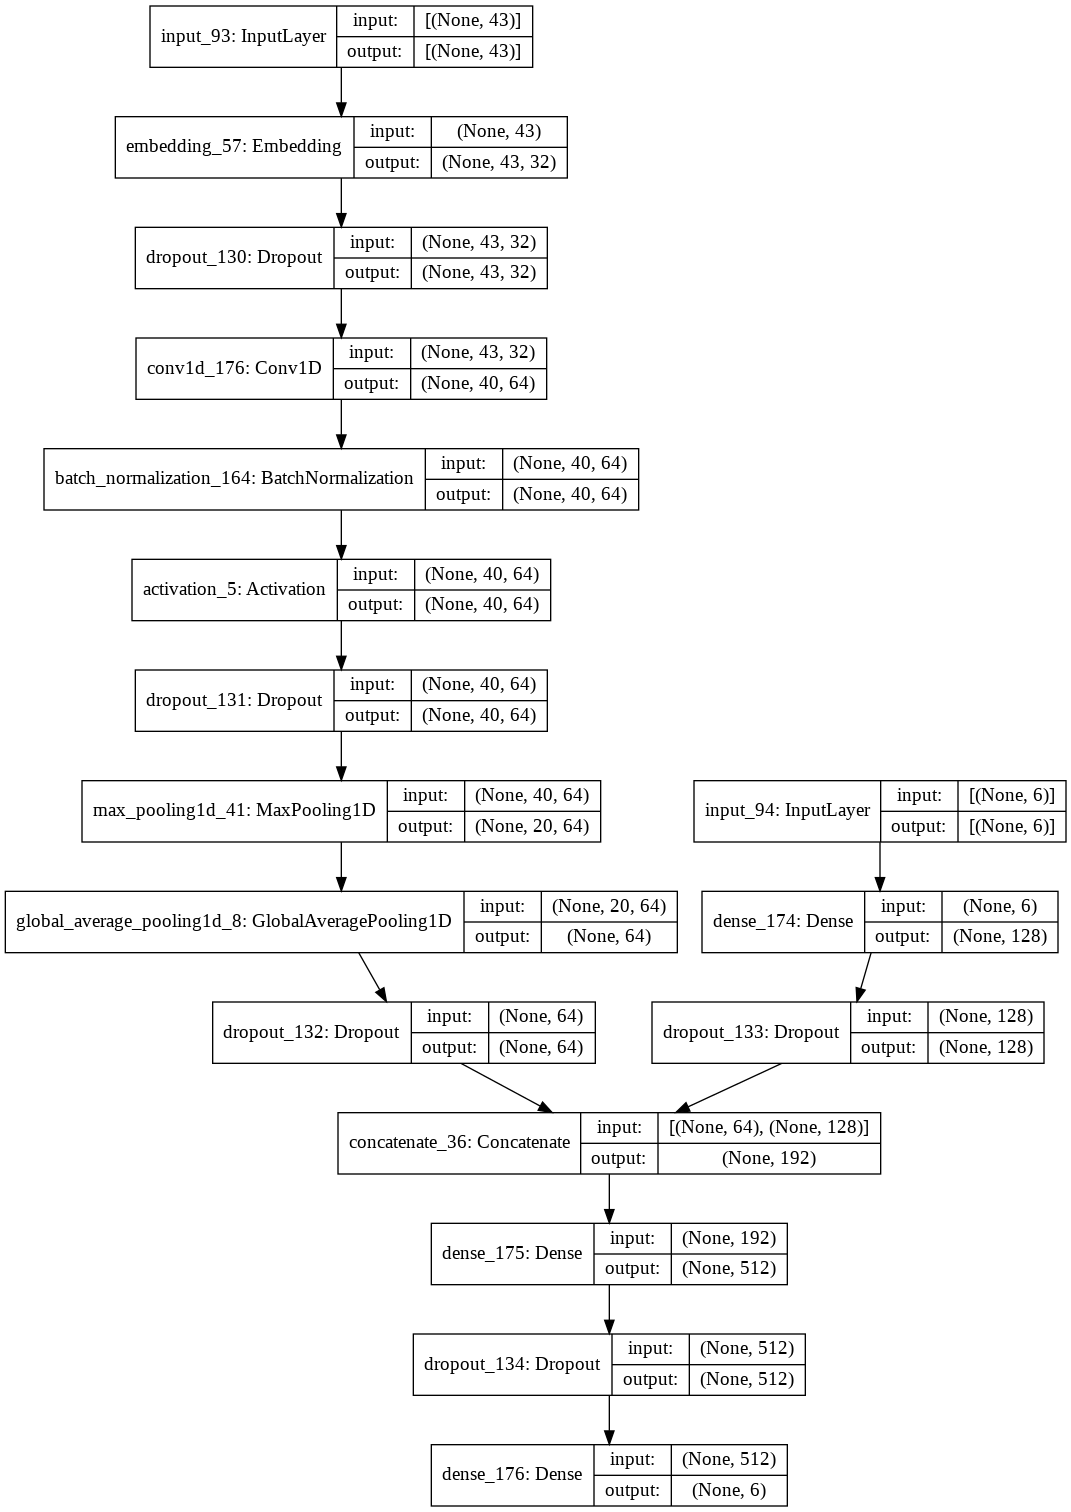

In [277]:
plot_model(cnn_model[2], to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [278]:
cnn_model[2].summary()

Model: "model_32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_93 (InputLayer)           [(None, 43)]         0                                            
__________________________________________________________________________________________________
embedding_57 (Embedding)        (None, 43, 32)       2330144     input_93[0][0]                   
__________________________________________________________________________________________________
dropout_130 (Dropout)           (None, 43, 32)       0           embedding_57[0][0]               
__________________________________________________________________________________________________
conv1d_176 (Conv1D)             (None, 40, 64)       8256        dropout_130[0][0]                
___________________________________________________________________________________________

In [229]:
# Train the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)
adam = tf.keras.optimizers.Adam(lr=0.01)
loss = ['mean_absolute_error',
        'mean_absolute_error',
        'sparse_categorical_crossentropy']
metric = ['mean_absolute_error',
          'mean_absolute_error',
          'accuracy']          
Y = [Ytrain, Ytrain_scaled, Ytrain_trans]
history = {}
for i, name in enumerate(['first', 'second', 'third']):
  print('Training the %s model' %name)
  # Compile the model
  cnn_model[i].compile(loss=loss[i], optimizer=adam, metrics=[metric[i]])
  # Fit the model to the data
  history[i] = cnn_model[i].fit([Xtrain, Xtrain2], Y[i],
                                batch_size=512,
                                epochs=10,
                                callbacks=callback)
  

Training the first model
Epoch 1/10
667/667 [==============================] - 15s 20ms/step - loss: 110.9739 - mean_absolute_error: 110.9739
Epoch 2/10
667/667 [==============================] - 14s 21ms/step - loss: 110.4207 - mean_absolute_error: 110.4207
Epoch 3/10
667/667 [==============================] - 13s 20ms/step - loss: 109.7840 - mean_absolute_error: 109.7840
Epoch 4/10
667/667 [==============================] - 14s 20ms/step - loss: 108.5518 - mean_absolute_error: 108.5518
Epoch 5/10
667/667 [==============================] - 14s 20ms/step - loss: 109.5102 - mean_absolute_error: 109.5102
Epoch 6/10
667/667 [==============================] - 14s 20ms/step - loss: 106.8942 - mean_absolute_error: 106.8942
Epoch 7/10
667/667 [==============================] - 14s 20ms/step - loss: 103.2923 - mean_absolute_error: 103.2923
Epoch 8/10
667/667 [==============================] - 14s 20ms/step - loss: 103.1573 - mean_absolute_error: 103.1573
Epoch 9/10
667/667 [===================

In [235]:
# Plot
description = ['Original test set',
               'Rescaled test set',
               'transforemd test set']
def predict_and_plot(model, xtest):    
  fig, ax = plt.subplots(3,2, figsize=(10,10))
  for i, ytest in enumerate([Ytest, Ytest_scaled, Ytest_trans]):
    pred = model[i].predict(xtest)
    if i == 2: pred = [np.argmax(x) for x in pred]
    ax[i,0].plot(np.arange(50), pred[:50], label='predictions')
    ax[i,0].plot(np.arange(50), ytest[:50], label='%s' %description[i])
    ax[i,0].set_title('Short-term predictions')
    ax[i,0].legend()

    sns.distplot(pred, ax=ax[i,1], label='predictions')
    sns.distplot(ytest, ax=ax[i,1], label='%s' %description[i])
    ax[i,1].set_title('Long-term predictions')
    ax[i,1].legend()
    plt.tight_layout()

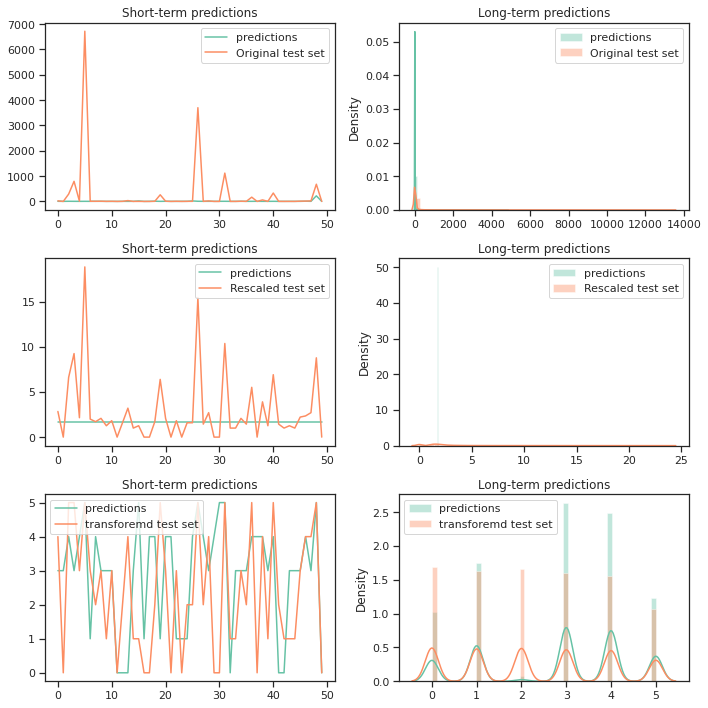

In [239]:
predict_and_plot(cnn_model, [Xtest, Xtest2])

# TensorFlow Hub

We can use a pre-trained text embedding as the first layer from TensorFlow Hub called google/nnlm-en-dim50/2.

In [293]:
# Preprocess the input. The output of this function is a tf.string object 
# which can be passed to the hub_layer
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  return tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [294]:
X1, X2 = train_test_split(df.title,
                          test_size=0.33,
                          random_state=42)
Xtrain_tensor = custom_standardization(X1)
Xtest_tensor = custom_standardization(X2)

In [295]:
import tensorflow_hub as hub

embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_model = {}

for i in range(3):
  hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                            dtype=tf.string, trainable=True)

  hub_model[i] = tf.keras.Sequential()
  hub_model[i].add(hub_layer)
  hub_model[i].add(tf.keras.layers.Dense(16, activation='relu'))
  if i !=2: 
    hub_model[i].add(tf.keras.layers.Dense(1))
  else: 
    hub_model[i].add(tf.keras.layers.Dense(6, activation='softmax'))


In [285]:
hub_model[1].summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_10 (KerasLayer)  (None, 50)                48190600  
_________________________________________________________________
dense_191 (Dense)            (None, 16)                816       
_________________________________________________________________
dense_192 (Dense)            (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [165]:
# Train the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)
adam = tf.keras.optimizers.Adam(lr=0.01)
loss = ['mean_absolute_error',
        'mean_absolute_error',
        'sparse_categorical_crossentropy']
metric = ['mean_absolute_error',
          'mean_absolute_error',
          'accuracy']          
Y = [Ytrain, Ytrain_scaled, Ytrain_trans]
history_3 = {}

for i, name in enumerate(['first', 'second', 'third']):
  print('Training the %s model' %name)
  # Compile the model
  hub_model[i].compile(loss=loss[i], optimizer=adam, metrics=[metric[i]])
  # Fit the model to the data
  history_3[i] = hub_model[i].fit(Xtrain_tensor, Y[i],
                                batch_size=512,
                                epochs=10,
                                callbacks=callback)


Training the first model
Epoch 1/10
667/667 [==============================] - 9s 12ms/step - loss: 112.3648 - mean_absolute_error: 112.3648
Epoch 2/10
667/667 [==============================] - 8s 12ms/step - loss: 110.1475 - mean_absolute_error: 110.1475
Epoch 3/10
667/667 [==============================] - 8s 12ms/step - loss: 110.7793 - mean_absolute_error: 110.7793
Epoch 4/10
667/667 [==============================] - 8s 12ms/step - loss: 111.3741 - mean_absolute_error: 111.3741
Epoch 5/10
667/667 [==============================] - 8s 12ms/step - loss: 107.7695 - mean_absolute_error: 107.7695
Epoch 6/10
667/667 [==============================] - 8s 12ms/step - loss: 107.1163 - mean_absolute_error: 107.1163
Epoch 7/10
667/667 [==============================] - 8s 12ms/step - loss: 105.3984 - mean_absolute_error: 105.3984
Epoch 8/10
667/667 [==============================] - 8s 12ms/step - loss: 106.7215 - mean_absolute_error: 106.7215
Epoch 9/10
667/667 [===========================

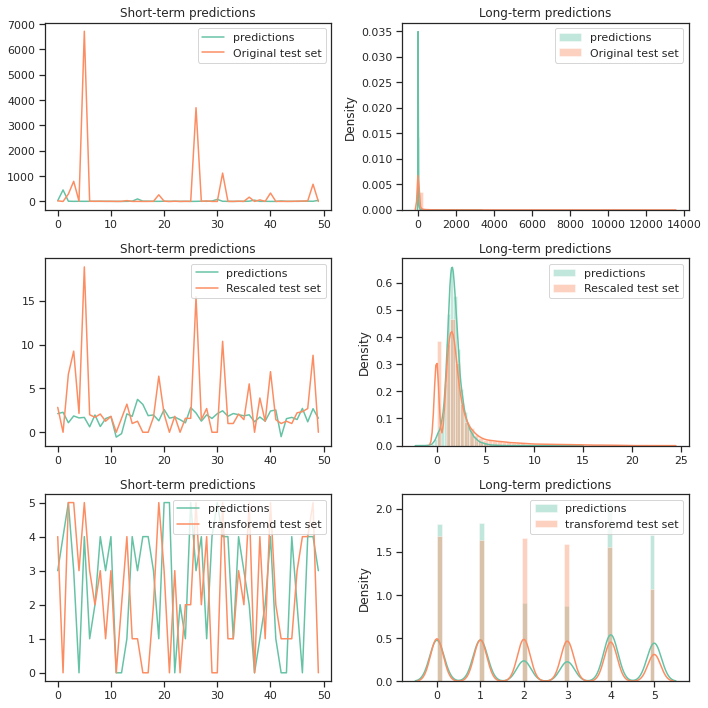

In [238]:
predict_and_plot(hub_model, Xtest_tensor)

# RNN/LSTM

The first layer is the encoder, which converts the text to a sequence of token indices.

After the encoder is an embedding  layer which I explained about it in CNN section.


The tf.keras.layers.Bidirectional can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.

The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.

In [286]:
Xtrain_new, Xtest_new = train_test_split(df.title.to_numpy(),
                                         test_size=0.33,
                                         random_state=42)                                       

In [287]:
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=None)
encoder.adapt(Xtrain_new)

In [288]:
rnn_model = {}

for i in range(3):
  rnn_model[i] = tf.keras.Sequential()
  rnn_model[i].add(encoder)
  rnn_model[i].add(tf.keras.layers.Embedding(
          input_dim=len(encoder.get_vocabulary()),
          output_dim=64,
          mask_zero=True))
  rnn_model[i].add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
  rnn_model[i].add(tf.keras.layers.Dense(64, activation='relu'))
  if i != 2:
    rnn_model[i].add(tf.keras.layers.Dense(1))
  else: 
    rnn_model[i].add(tf.keras.layers.Dense(6, activation='softmax'))
     

In [234]:
# Train the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)
adam = tf.keras.optimizers.Adam(lr=0.01)
loss = ['mean_absolute_error',
        'mean_absolute_error',
        'sparse_categorical_crossentropy']
metric = ['mean_absolute_error',
          'mean_absolute_error',
          'accuracy']          
Y = [Ytrain, Ytrain_scaled, Ytrain_trans]
history_4 = {}

for i, name in enumerate(['first', 'second', 'third']):
  print('Training the %s model' %name)
  # Compile the model
  rnn_model[i].compile(loss=loss[i], optimizer=adam, metrics=[metric[i]])
  # Fit the model to the data
  history_4[i] = rnn_model[i].fit(Xtrain_new, Y[i],
                                batch_size=512,
                                epochs=20,
                                callbacks=callback)

Training the first model
Epoch 1/20
667/667 [==============================] - 50s 61ms/step - loss: 112.7434 - mean_absolute_error: 112.7434
Epoch 2/20
667/667 [==============================] - 41s 61ms/step - loss: 110.6899 - mean_absolute_error: 110.6899
Epoch 3/20
667/667 [==============================] - 41s 61ms/step - loss: 110.2379 - mean_absolute_error: 110.2379
Epoch 4/20
667/667 [==============================] - 40s 61ms/step - loss: 107.2414 - mean_absolute_error: 107.2414
Epoch 5/20
667/667 [==============================] - 41s 61ms/step - loss: 106.9406 - mean_absolute_error: 106.9406
Epoch 6/20
667/667 [==============================] - 40s 61ms/step - loss: 102.7486 - mean_absolute_error: 102.7486
Epoch 7/20
667/667 [==============================] - 40s 61ms/step - loss: 102.5145 - mean_absolute_error: 102.5145
Epoch 8/20
667/667 [==============================] - 40s 60ms/step - loss: 100.6839 - mean_absolute_error: 100.6839
Epoch 9/20
667/667 [===================

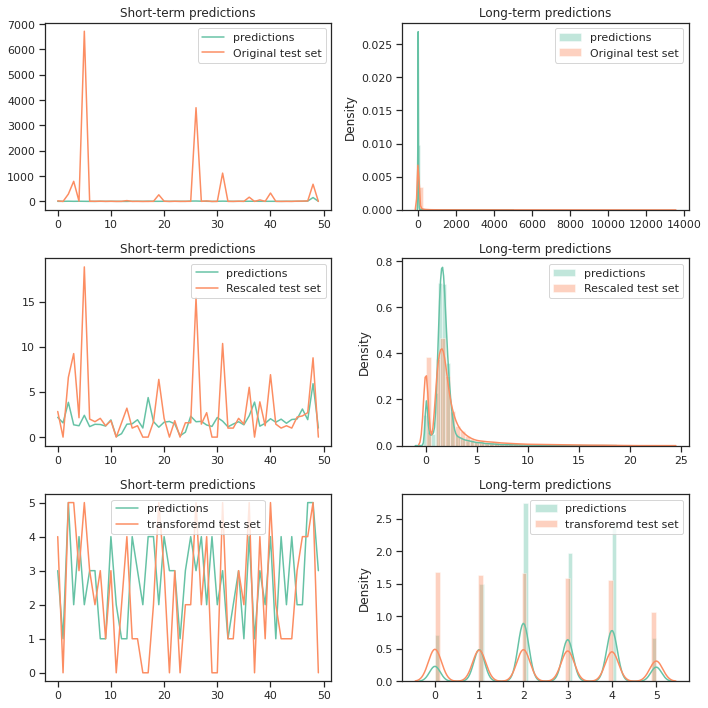

In [236]:
predict_and_plot(rnn_model, Xtest_new)

Both real data and predictions have almost the same shape for density plot.

# VDCNN


This is a model based on the paper: https://arxiv.org/abs/1606.01781. It is invented for the purpose of text classification.
A TensorFlow implementation of this network can be found here:
https://github.com/cjiang2/VDCNN. I have used this code for regression and classification.

In [289]:
import tensorflow as tf
from tensorflow.keras import Model, layers

N_BLOCKS = {9: (1, 1, 1, 1),
            17: (2, 2, 2, 2),
            29: (5, 5, 2, 2),
            49:(8, 8, 5, 3)}

class KMaxPooling(layers.Layer):
    """
    K-max pooling layer that extracts the k-highest activations from a sequence (2nd dimension).
    TensorFlow backend.
    """
    def __init__(self, 
                 k=None, 
                 sorted=False):
        super(KMaxPooling, self).__init__()
        self.k = k
        self.sorted = sorted

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.k, input_shape[2])

    def call(self, 
             inputs):
        if self.k is None:
            k = int(tf.round(inputs.shape[1] / 2))
        else:
            k = self.k

        # Swap last two dimensions since top_k will be applied along the last dimension
        shifted_inputs = tf.transpose(inputs, [0, 2, 1])
        
        # Extract top_k, returns two tensors [values, indices]
        top_k = tf.nn.top_k(shifted_inputs, k=k, sorted=self.sorted)[0]
        
        # return flattened output
        return tf.transpose(top_k, [0, 2, 1])

class Pooling(layers.Layer):
    """Wrapper for different pooling operations.
    Including maxpooling and k-maxpooling.
    """
    def __init__(self, 
                 pool_type='max',
                 name=None):
        super(Pooling, self).__init__(name=name)
        assert pool_type in ['max', 'k_max']
        self.pool_type = pool_type

        if pool_type == 'max':
            self.pool = layers.MaxPooling1D(pool_size=3, strides=2, padding='same')
        elif pool_type == 'k_max':
            self.pool = KMaxPooling()
        
    def call(self, 
             x):
        return self.pool(x)

class ZeroPadding(layers.Layer):
    def __init__(self, 
                 values,
                 name=None):
        super(ZeroPadding, self).__init__(name=name)
        self.values = values

    def call(self, 
             x):
        x = tf.pad(x, [[0, 0], [0, 0], [self.values[0], self.values[1]]], 
                   mode='CONSTANT', constant_values=0)
        return x

class Conv1D_BN(layers.Layer):
    """A stack of conv 1x1 and BatchNorm.
    """
    def __init__(self, 
                 filters,
                 kernel_size=3,
                 strides=2,
                 padding='same',
                 use_bias=True,
                 name=None):
        super(Conv1D_BN, self).__init__(name=name)
        self.filters = filters
        self.use_bias = use_bias
        self.conv = layers.Conv1D(filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias,
                                  kernel_initializer='he_normal')
        self.bn = layers.BatchNormalization()

    def call(self, 
             x):
        x = self.conv(x)
        x = self.bn(x)
        return x
    

class ConvBlock(layers.Layer):
    """Conv block with downsampling.
    1x1 conv to increase dimensions.
    """
    def __init__(self, 
                 filters, 
                 kernel_size=3,
                 use_bias=True,
                 shortcut=True,
                 pool_type=None,
                 proj_type=None,
                 name=None,
                 ):
        super(ConvBlock, self).__init__(name=name)
        self.filters = filters
        self.kernel_size = kernel_size
        self.use_bias = use_bias
        self.shortcut = shortcut
        self.pool_type = pool_type
        self.proj_type = proj_type

        # Deal with downsample and pooling
        assert pool_type in ['max', 'k_max', 'conv', None]
        if pool_type is None:
            strides = 1
            self.pool = None
            self.downsample = None

        elif pool_type == 'conv':
            strides = 2     # Convolutional pooling with stride 2
            self.pool = None
            if shortcut:
                self.downsample = Conv1D_BN(filters, 3, strides=2, padding='same', use_bias=use_bias)
        
        else:
            strides = 1
            self.pool = Pooling(pool_type)
            if shortcut:
                self.downsample = Conv1D_BN(filters, 3, strides=2, padding='same', use_bias=use_bias)

        self.conv1 = layers.Conv1D(filters, kernel_size, strides=strides, padding='same', use_bias=use_bias, 
                                   kernel_initializer='he_normal')
        self.bn1 = layers.BatchNormalization()

        self.conv2 = layers.Conv1D(filters, kernel_size, strides=1, padding='same', use_bias=use_bias,
                                   kernel_initializer='he_normal')
        self.bn2 = layers.BatchNormalization()

        assert proj_type in ['identity', 'conv', None]
        if shortcut:
            if proj_type == 'conv':
                # 1x1 conv for projection
                self.proj = Conv1D_BN(filters*2, 1, strides=1, padding='same', use_bias=use_bias)

            elif proj_type == 'identity':
                # Identity using zero padding
                self.proj = ZeroPadding([int(filters // 2), filters - int(filters // 2)])

    def call(self, 
             x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = tf.nn.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.pool is not None:
            out = self.pool(out)

        if self.shortcut:
            if self.downsample is not None:
                residual = self.downsample(residual)
            out += residual

        out = tf.nn.relu(out)

        if self.proj_type is not None and self.shortcut:
            out = self.proj(out)

        return out

class VDCNN(Model):
    """Model codebase for VDCNN.
    Args:
        num_classes: No. classes for classification task.
        depth: depth of VDCNN, one of [9, 17, 29, 49].
        seqlen: Sequence length.
        embed_dim: dim for character embeddings.
        shortcut: Use skip connections.
        pool_type: Pooling operations to be used, one of ['max', 'k_max', 'conv'].
        proj_type: Operation to increase dim for dotted skip connection, one of ['identity', 'conv'].
        use_bias: Use bias for all layers or not.
        logits: If False, return softmax probs.
    """
    def __init__(self, 
                 num_classes,
                 depth=9, 
                 vocab_size=72816,
                 seqlen=None,
                 embed_dim=16,
                 shortcut=True, 
                 pool_type='max',
                 proj_type='conv',
                 use_bias=True,
                 logits=True):
        super(VDCNN, self).__init__()
        self.num_classes = num_classes
        self.depth = depth
        self.vocab_size = vocab_size
        self.seqlen = seqlen
        self.embed_dim = embed_dim
        self.shortcut = shortcut
        self.pool_type = pool_type
        self.proj_type = proj_type
        self.use_bias = use_bias
        self.logits = True

        assert pool_type in ['max', 'k_max', 'conv']
        assert proj_type in ['conv', 'identity']
        self.n_blocks = N_BLOCKS[depth]

        self.embed_char = layers.Embedding(vocab_size+1, embed_dim, input_length=seqlen)
        self.conv = layers.Conv1D(64, 3, strides=1, padding='same', use_bias=use_bias, 
                                  kernel_initializer='he_normal')

        # Convolutional Block 64
        self.conv_block_64 = []
        for _ in range(self.n_blocks[0] - 1):
            self.conv_block_64.append(ConvBlock(64, 3, use_bias, shortcut))
        self.conv_block_64.append(ConvBlock(64, 3, use_bias, shortcut, pool_type=pool_type, proj_type=proj_type))

        # Convolutional Block 128
        self.conv_block_128 = []
        for _ in range(self.n_blocks[1] - 1):
            self.conv_block_128.append(ConvBlock(128, 3, use_bias, shortcut))
        self.conv_block_128.append(ConvBlock(128, 3, use_bias, shortcut, pool_type=pool_type, proj_type=proj_type))

        # Convolutional Block 256
        self.conv_block_256 = []
        for _ in range(self.n_blocks[2] - 1):
            self.conv_block_256.append(ConvBlock(256, 3, use_bias, shortcut))
        self.conv_block_256.append(ConvBlock(256, 3, use_bias, shortcut, pool_type=pool_type, proj_type=proj_type))

        # Convolutional Block 512
        self.conv_block_512 = []
        for _ in range(self.n_blocks[3] - 1):
            self.conv_block_512.append(ConvBlock(512, 3, use_bias, shortcut))
        self.conv_block_512.append(ConvBlock(512, 3, use_bias, shortcut, pool_type=None, proj_type=None))

        self.k_maxpool = KMaxPooling(k=6)
        self.flatten = layers.Flatten()

        # Dense layers
        self.fc1 = layers.Dense(2048, activation='relu')
        self.out = layers.Dense(2048, activation='relu')
        #self.out = layers.Dense(num_classes)

    def call(self,
             x):
        x = self.embed_char(x)
        #print('embed:', x.shape)
        x = self.conv(x)
        #print('conv:', x.shape)

        for l in self.conv_block_64:
            x = l(x)
        #print('conv_block_64:', x.shape)

        for l in self.conv_block_128:
            x = l(x)
        #print('conv_block_128:', x.shape)

        for l in self.conv_block_256:
            x = l(x)
        #print('conv_block_256:', x.shape)

        for l in self.conv_block_512:
            x = l(x)
        #print('conv_block_512:', x.shape)

        x = self.k_maxpool(x)
        #print('k_maxpool_8:', x.shape)
        x = self.flatten(x)
        #print('flatten:', x.shape)

        x = self.fc1(x)
        #x = self.fc2(x)
        out = self.out(x)
        #print('out:', out.shape)

        if self.logits:
            return out
        
        return tf.nn.softmax(out)

if __name__ == "__main__":
    x = tf.zeros([4, 1014])
    model = VDCNN(1, depth=9, shortcut=True, pool_type='max', proj_type='identity')
    out = model(x)
    model.summary()
    print()
    # model = VDCNN(10, depth=17, shortcut=True, pool_type='k_max', proj_type='identity')
    # out = model(x)
    # model.summary()

    # print()
    # model = VDCNN(10, depth=29, shortcut=False, pool_type='max', proj_type='conv')
    # out = model(x)
    # model.summary()

    # print()
    # model = VDCNN(10, depth=49, shortcut=True, pool_type='conv', proj_type='conv')
    # out = model(x)
    # model.summary()

Model: "vdcnn_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_61 (Embedding)     multiple                  1165072   
_________________________________________________________________
conv1d_177 (Conv1D)          multiple                  3136      
_________________________________________________________________
conv_block_48 (ConvBlock)    multiple                  37824     
_________________________________________________________________
conv_block_49 (ConvBlock)    multiple                  149376    
_________________________________________________________________
conv_block_50 (ConvBlock)    multiple                  593664    
_________________________________________________________________
conv_block_51 (ConvBlock)    multiple                  1577984   
_________________________________________________________________
k_max_pooling_12 (KMaxPoolin multiple                  0  

In [292]:
max_features = max(np.max(Xtrain), np.max(Xtest))
max_length = Xtrain.shape[1]
vdcnn_model = {}

# First network for the input which includes word indexes.
for i in range(3):
  input_x = Input(shape=(max_length,))
  output_x = VDCNN(1, depth=9, 
                   vocab_size=max_features,
                   seqlen=max_length,
                   embed_dim=16,
                   shortcut=True, 
                   pool_type='max',
                   proj_type='conv',
                   use_bias=True,
                   logits=True)(input_x)

  # Second network for the input which includes other features. 
  input_y = Input(shape=(6,))
  y = Dense(128, activation='relu')(input_y)
  output_y = Dropout(0.5)(y)

  # Merge two outputs and pass to the third network to get the final output.
  merge = concatenate([output_x, output_y], axis=1)
  z = Dense(1024, activation='relu')(merge)
  z = Dropout(0.5)(z)
  if i != 2: 
    output = Dense(1)(z)
  else:
    output = Dense(6, activation='softmax')(z)
    
  vdcnn_model[i] = Model(inputs=[input_x, input_y], outputs=[output])

In [291]:
vdcnn_model[2].summary()

Model: "model_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_100 (InputLayer)          [(None, 6)]          0                                            
__________________________________________________________________________________________________
input_99 (InputLayer)           [(None, 43)]         0                                            
__________________________________________________________________________________________________
dense_215 (Dense)               (None, 128)          896         input_100[0][0]                  
__________________________________________________________________________________________________
vdcnn_16 (VDCNN)                (None, 2048)         14193424    input_99[0][0]                   
___________________________________________________________________________________________

In [219]:
# Train the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)
sgd = tf.keras.optimizers.SGD(lr=0.01, decay=0.9)
loss = ['mean_absolute_error',
        'mean_absolute_error',
        'sparse_categorical_crossentropy']
metric = ['mean_absolute_error',
          'mean_absolute_error',
          'accuracy']          
Y = [Ytrain, Ytrain_scaled, Ytrain_trans]
history_5 = {}

for i, name in enumerate(['first', 'second', 'third']):
  print('Training the %s model' %name)
  # Compile the model
  vdcnn_model[i].compile(loss=loss[i], optimizer=sgd, metrics=[metric[i]])
  # Fit the model to the data
  history_5[i] = vdcnn_model[i].fit([Xtrain, Xtrain2], Y[i],
                                batch_size=512,
                                epochs=10,
                                callbacks=callback)

Training the first model
Epoch 1/10
667/667 [==============================] - 100s 144ms/step - loss: 111.0371 - mean_absolute_error: 111.0371
Epoch 2/10
667/667 [==============================] - 96s 143ms/step - loss: 110.8514 - mean_absolute_error: 110.8514
Epoch 3/10
667/667 [==============================] - 96s 143ms/step - loss: 111.4501 - mean_absolute_error: 111.4501
Epoch 4/10
667/667 [==============================] - 95s 143ms/step - loss: 110.0847 - mean_absolute_error: 110.0847
Epoch 5/10
667/667 [==============================] - 95s 143ms/step - loss: 111.7950 - mean_absolute_error: 111.7950
Epoch 6/10
667/667 [==============================] - 96s 143ms/step - loss: 109.4174 - mean_absolute_error: 109.4174
Epoch 7/10
667/667 [==============================] - 96s 143ms/step - loss: 111.2943 - mean_absolute_error: 111.2943
Epoch 8/10
667/667 [==============================] - 95s 143ms/step - loss: 111.6840 - mean_absolute_error: 111.6840
Epoch 9/10
667/667 [==========

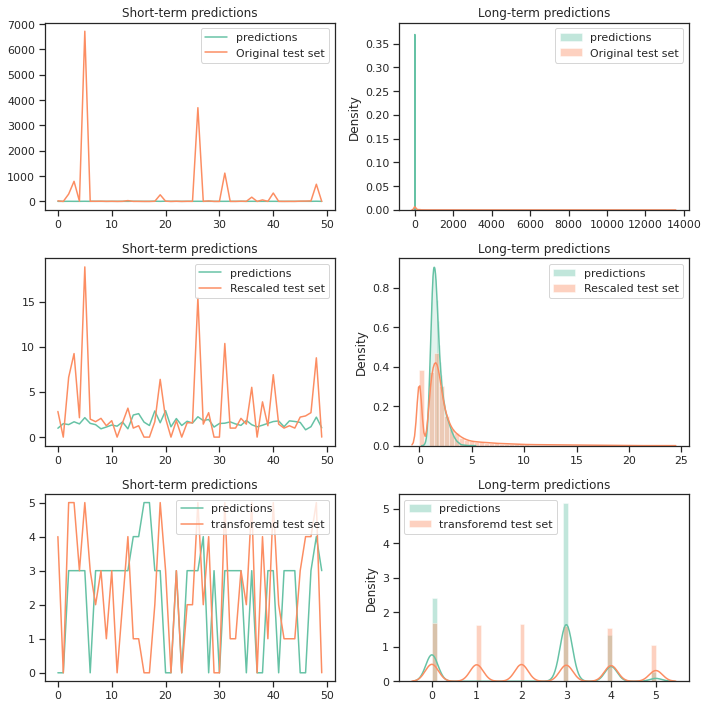

In [237]:
predict_and_plot(vdcnn_model, [Xtest, Xtest2])